# Exploratory Data Analysis

In this section, we seek to find any significant confounding factor that may drive the demand in specific location. This section will help us develop deeper understanding of the data and narrow down the significant features for our predictions/classifications later.

In [1]:
import sys
sys.path.append('../')
from scripts.preprocess import preprocess, transform_demand
from scripts.pluto_datascrape import get_merged_zone_data
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.types import BooleanType
import shapefile as shp
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import holidays


%matplotlib inline
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))

In [2]:
# Starting a Spark session
spk = (
    SparkSession.builder.appName('Playground')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

# Read the parquet dataset
df = spk.read.parquet('/Users/oliver/Downloads/MAST30034_Python-main/data/tlc_data')


# TLC Taxi Dataset

In [3]:
# Clean the raw TLC taxi dataset
df = preprocess(df)

# Get the daily demand data
pickup_daily_demand, dropoff_daily_demand = transform_demand(df)


# Get the hourly demand data
pickup_hourly_demand, dropoff_hourly_demand = transform_demand(df, 'hour')

In [4]:
pickup_daily_demand

pu_location_id,pickup_date,count
55,2022-03-01,3
229,2022-03-02,2360
113,2022-03-02,1493
225,2022-03-02,7
34,2022-03-03,3
191,2022-03-05,3
235,2022-03-05,6
141,2022-03-07,2339
129,2022-03-07,12
125,2022-03-11,594


# PLUTO and TLC Zone Data

In [5]:
# Read the shapefile of the tlc zone dataset
sf = gpd.read_file("/Users/oliver/Downloads/taxi_zones/taxi_zones.shp")
zones = pd.read_csv("/Users/oliver/Downloads/taxi_zones/taxi+_zone_lookup.csv")


In [6]:
# Get PLUTO and TLC Zone merged data
sjoined_df = get_merged_zone_data(sf, zones)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
../scripts/pluto_datascrape.py:95: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs + ...

  pluto_gdf, tlc_gdf, op='within'


## Summary Statistics

In [14]:
# Tabulate summary statistics
operations = [func.mean, func.stddev, func.min, func.max]
exprs = [f(func.col("count")) for f in operations]

location_hourly_statistics = pickup_hourly_demand.groupby(['pu_location_id', 'pickup_date']).agg(*exprs)
location_daily_statistics = pickup_daily_demand.groupby('pu_location_id').agg(*exprs)

In [64]:
# Examine the statistics of hourly demand focusing on standard deviation
location_hourly_statistics.sort((func.col("stddev_samp(count)").desc()))

pu_location_id,pickup_date,avg(count),stddev_samp(count),min(count),max(count)
161,2022-03-23,241.79166666666666,197.88841369661418,3,596
237,2021-11-03,282.5,196.57966633757243,2,586
79,2021-11-07,166.875,192.06165506895454,18,937
237,2021-11-04,280.2916666666667,190.7343883101785,2,551
161,2022-03-24,243.83333333333334,190.34240695141474,3,567
161,2022-03-29,238.95833333333334,190.24754564300798,3,605
237,2021-11-17,277.3333333333333,190.2048476195363,3,531
161,2022-03-15,223.375,190.0907820878819,1,595
236,2021-11-23,239.29166666666666,187.981377238294,3,566
237,2021-11-18,279.3333333333333,187.7738386803487,2,516


In [17]:
# Examine the statistics of daily demand focusing on standard deviation
location_daily_statistics.sort(func.col("stddev_samp(count)").desc())

pu_location_id,avg(count),stddev_samp(count),min(count),max(count)
237,4682.702830188679,1307.7923336863635,762,6906
161,3827.735849056604,1120.7883591505276,526,5852
79,2544.490566037736,1117.0256608175105,758,5330
236,4235.051886792453,1107.3893350918165,779,6050
132,3926.6367924528304,890.3149637929514,416,5858
162,3156.8915094339623,865.6039518418085,562,4789
138,2714.051886792453,712.2917370165231,50,4369
249,2104.8490566037735,671.1677351950688,631,3763
163,2782.801886792453,666.5720529675474,550,3979
142,3224.877358490566,664.0159123147632,1036,4552


Here we notice that most of the locations with high standard deviations are located at city center. We hypothesize that this is due to the confounding effects of day in the week (more crowded in the city during weekends and public holidays) as well as weather of the day.

To check if this is the case, we can split the daily demand dataset into weekdays and weekends (including public holidays) to see if the standard deviation reduces significantly.

In [67]:
# Create a column to categorise weekday and weekend/public holiday
us_holidays = holidays.US(state='NY', years=[2021,2022])

is_weekday = ((func.dayofweek(func.col('pickup_date')).between(2,6)) 
             & (~func.col('pickup_date').isin(list(us_holidays.keys()))))

pickup_daily_demand = (pickup_daily_demand
                       .withColumn('day_of_week', func.dayofweek(func.col('pickup_date')))
                       .withColumn('is_weekday', is_weekday)
)

In [84]:
df_229 = pickup_daily_demand.filter(func.col('pu_location_id') == 229).toPandas()

In [81]:
df_229

,pu_location_id,pickup_date,count,weekday,is_weekday,day_of_week
0,229,2022-03-02,2360,True,True,4
1,229,2021-11-04,2614,True,True,5
2,229,2022-03-14,1787,True,True,2
3,229,2022-04-15,2310,True,True,6
4,229,2022-04-12,2417,True,True,3
...,...,...,...,...,...,...
207,229,2022-02-09,2198,True,True,4
208,229,2022-04-25,1917,True,True,2
209,229,2021-12-26,887,False,False,1
210,229,2022-01-01,1187,False,False,7


<AxesSubplot:xlabel='pickup_date', ylabel='count'>

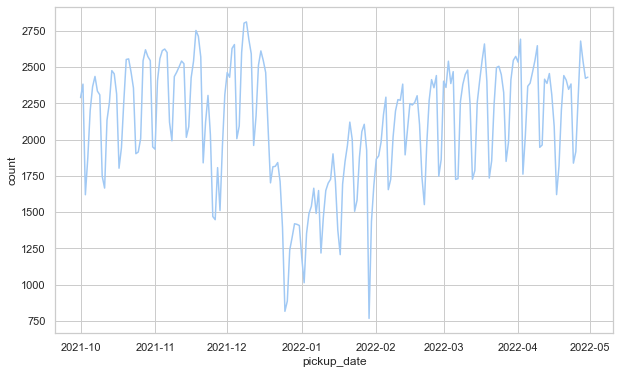

In [83]:
sns.lineplot(x='pickup_date', y='count', data=df_229)

In [57]:
pickup_weekday_demand = pickup_daily_demand.where(func.col('weekday') == True)


In [58]:
pickup_weekend_demand = pickup_daily_demand.where(func.col('weekday') == False)
pickup_weekend_demand

pu_location_id,pickup_date,count,weekday
191,2022-03-05,3,false
235,2022-03-05,6,false
209,2022-03-13,164,false
12,2022-03-20,37,false
89,2022-03-26,4,false
23,2022-04-03,3,false
117,2022-04-03,2,false
35,2022-04-09,1,false
192,2022-04-10,1,false
250,2022-04-10,2,false
